In [1]:
from PIL import Image

import requests
import io
import math
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy

import panopticapi
from panopticapi.utils import id2rgb, rgb2id

from PIL import Image
import cv2

torch.set_grad_enabled(False);

In [2]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0


assert(first_class_index in [0, 1])

if first_class_index == 0:
    num_classes = 3

    finetuned_classes = [
        'front_door',
        'rear_door',
        'not_door',
    ]
else:
    num_classes = 3
    finetuned_classes = [
        'NA/',
        'front_door',
        'rear_door',
        'not_door',
    ]


print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 3
Fine-tuned classes: [&#39;front_door&#39;, &#39;rear_door&#39;, &#39;not_door&#39;]


In [4]:
%cd ../..
%ls

/home/daniel/Work/detr
cab/                           main.py*           run_output_old/
d2/                            masks1.pt          runs/
datasets/                      masks2.pt          run_with_submitit.py*
detr-r50_panoptic_no-head.pth  models/            test_all.py*
Dockerfile*                    __pycache__/       test_mask176.pt
engine.py*                     README.md*         test_mask57.pt
hubconf.py*                    requirements.txt*  tox.ini*
LICENSE*                       run_output/        util/


In [8]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet50_panoptic', pretrained=False, return_postprocessor=True, num_classes=num_classes)
checkpoint = torch.load('run_output_old/2020_10_02-08:43 SEGM 3class (T:5K, V:200) P:2020_10_01-15:46/best.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

model.eval();

Using cache found in /home/daniel/.cache/torch/hub/facebookresearch_detr_master


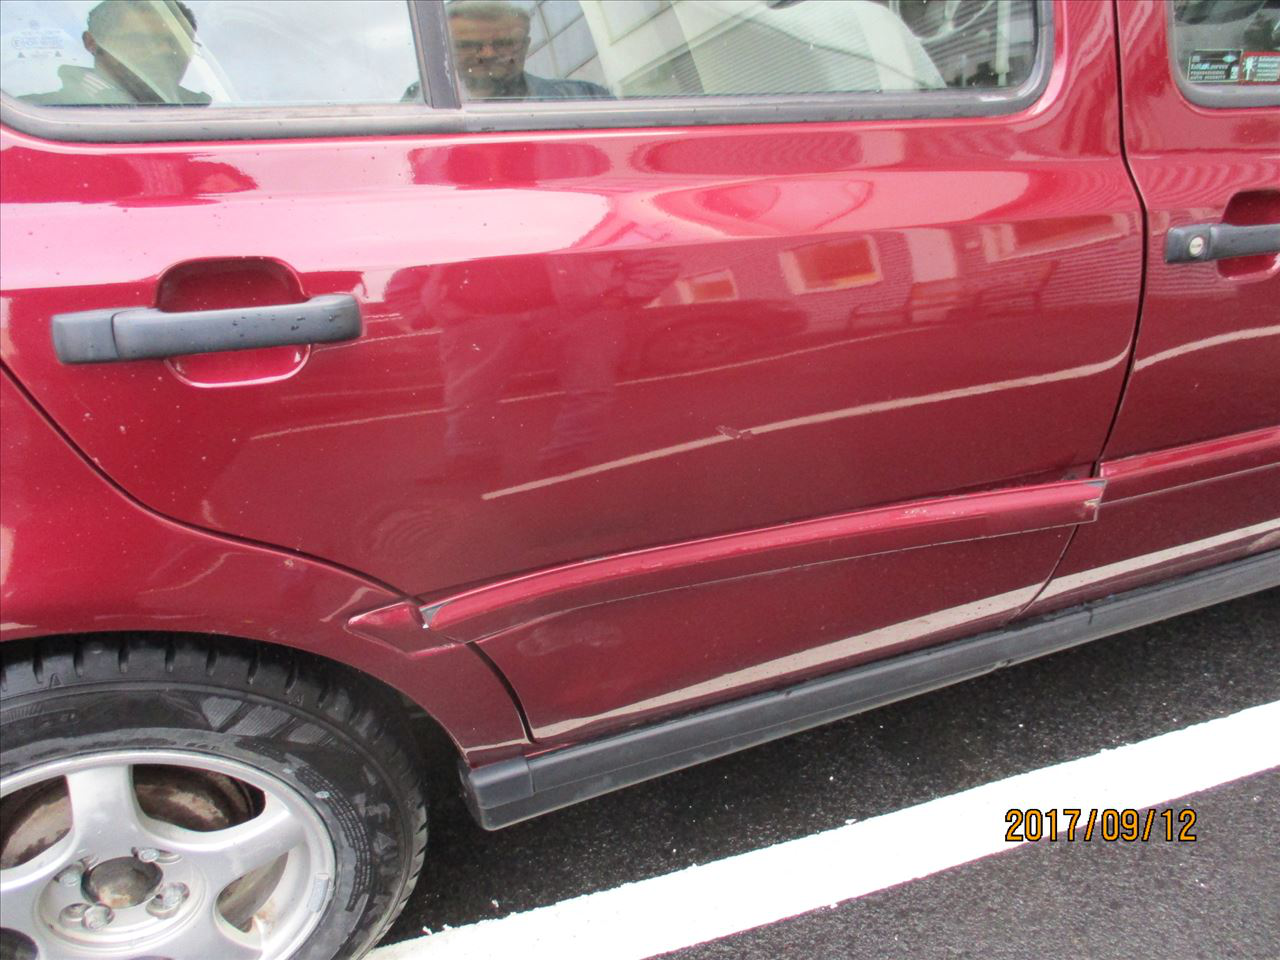

In [39]:
filename = '/mnt/data2/datasets/detr_mrcnn_compare/original/026.jpg'
im = Image.open(filename)
display(im)

In [40]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
out = model(img)

0


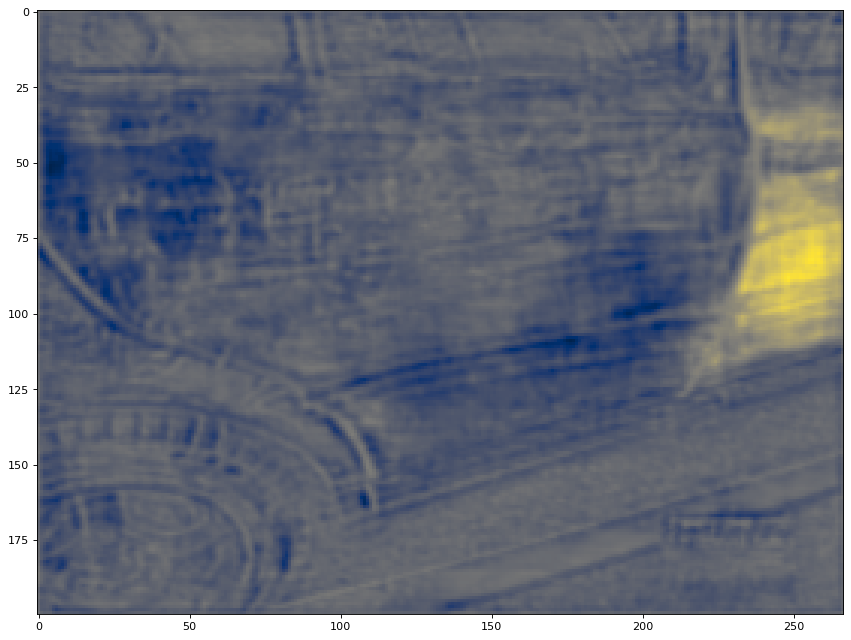

1


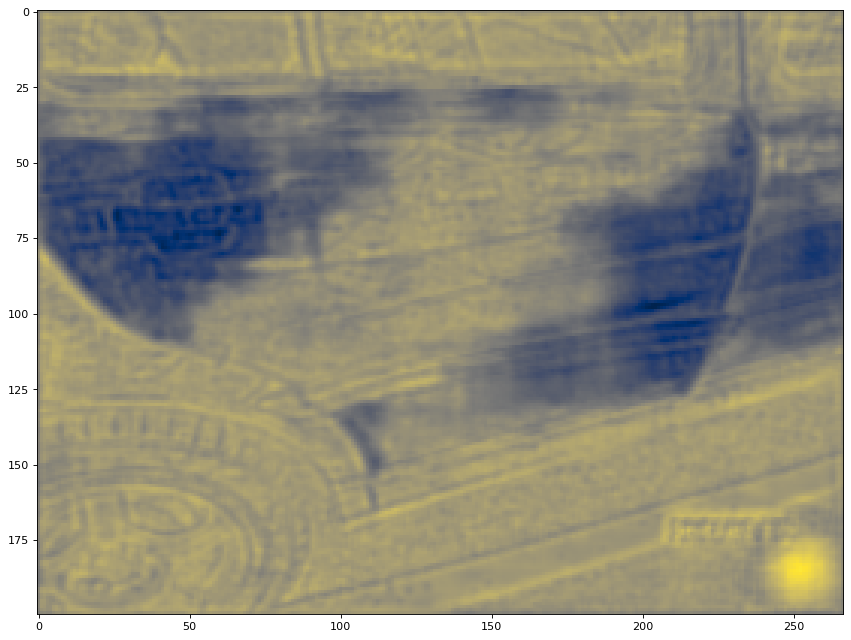

2


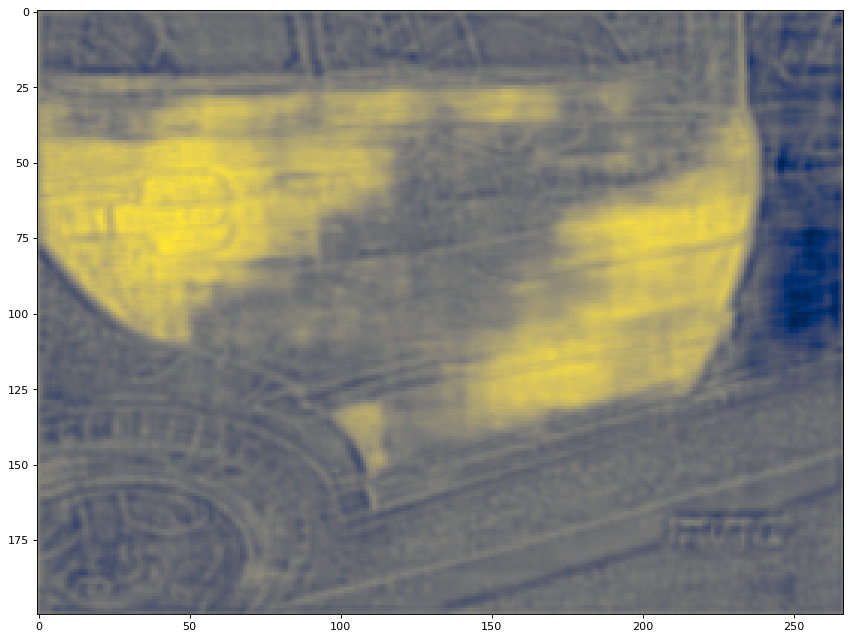

In [41]:
# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[...,:-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.7
# Plot all the remaining masks
ncols = 3
#fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item()*3 / ncols), figsize=(18, 10))
for i, mask in enumerate(out["pred_masks"][keep]):
    print(i)
    #positive_mask = torch.clamp(mask,min=0)
    #negative_mask = torch.clamp(mask, max=0)
    #ax = axs[i]#, i % ncols]
    #ax.imshow(mask, cmap="cividis")
    #ax.axis('off')

    plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(mask, cmap="cividis")
    plt.show()

    # ax = axs[i, 1]#, i % ncols]
    # ax.imshow(positive_mask, cmap="cividis")
    # ax.axis('off')

    # ax = axs[i, 2]#, i % ncols]
    # ax.imshow(negative_mask, cmap="cividis")
    # ax.axis('off')

fig.tight_layout()

In [42]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

[{&#39;id&#39;: 0, &#39;isthing&#39;: True, &#39;category_id&#39;: 0, &#39;area&#39;: 34096}, {&#39;id&#39;: 1, &#39;isthing&#39;: True, &#39;category_id&#39;: 2, &#39;area&#39;: 639399}, {&#39;id&#39;: 2, &#39;isthing&#39;: True, &#39;category_id&#39;: 1, &#39;area&#39;: 179305}]
&lt;PIL.PngImagePlugin.PngImageFile image mode=RGB size=1066x800 at 0x7F4CB6C3F640&gt;
0   [ 31 119 180]
1   [255 127  14]
2   [ 44 160  44]


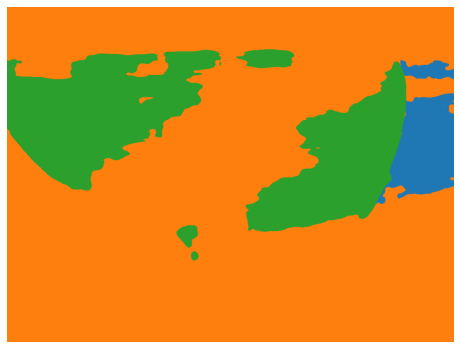

In [43]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())
segments_info = result["segments_info"]
print(segments_info)
# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
print(panoptic_seg)
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
  print(str(id) , ' ' , panoptic_seg[panoptic_seg_id == id][0])
plt.figure(figsize=(8,8))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

In [136]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


ImportError: /home/daniel/.conda/envs/pytorch/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so: undefined symbol: _ZN6caffe28TypeMeta21_typeMetaDataInstanceISt7complexIdEEEPKNS_6detail12TypeMetaDataEv

In [116]:
print('torch: ',torch.version)

torch:  <module 'torch.version' from '/home/daniel/.conda/envs/pytorch/lib/python3.8/site-packages/torch/version.py'>


In [112]:
from copy import deepcopy
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

    
    
# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
cv2_imshow(v.get_image())

NameError: name 'MetadataCatalog' is not defined